In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Store current working directory: curr_wd
curr_wd = os.getcwd()

# Store file name: file_rosters
file_rosters = 'Pittsburgh_Pirates_Roster_2015_2018.csv'

# Load file as a Pandas Dataframe: df_rosters_pirates
df_rosters_pirates = pd.read_csv(curr_wd + '/data_sources/' + file_rosters, parse_dates=['Date Of Birth'])

# Review the shape (rows, columns) of df_rosters_pirates
print(df_rosters_pirates.shape)

(196, 9)


Before we begin to think about the supervised learning models we can apply to this data, let's perform Exploratory data analysis (EDA) in order to understand the structure of the data. 


We'll begin by exploring the dataset numerically, leveraging the **.head()**, **.info()** and **.describe()** methods availabile with the **Pandas** libraries.

In [2]:
# Preview the dataset by viewing the first 5 rows of data.
print(df_rosters_pirates.head())

   Year Position   #               Player Height  Weight Throws   Bats  \
0  2015  Pitcher  59     Antonio Bastardo   5-11     202   Left  Right   
1  2015  Pitcher  55          Joe Blanton   6-03     225  Right  Right   
2  2015  Pitcher  34         A.J. Burnett   6-04     230  Right  Right   
3  2015  Pitcher  37  Arquimedes Caminero   6-04     245  Right  Right   
4  2015  Pitcher  45          Gerrit Cole   6-04     225  Right  Right   

  Date Of Birth  
0    1985-09-21  
1    1980-12-11  
2    1977-01-03  
3    1987-06-16  
4    1990-09-08  


In [3]:
# Review the completeness and data types within this dataset.
print(df_rosters_pirates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
Year             196 non-null int64
Position         196 non-null object
#                196 non-null object
Player           196 non-null object
Height           196 non-null object
Weight           196 non-null int64
Throws           196 non-null object
Bats             196 non-null object
Date Of Birth    196 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 13.9+ KB
None


In [5]:
# use less memory and increase performance for operations like groupby()
df_rosters_pirates['Position'] = df_rosters_pirates['Position'].astype('category')
df_rosters_pirates['Throws'] = df_rosters_pirates['Throws'].astype('category')
df_rosters_pirates['Bats'] = df_rosters_pirates['Bats'].astype('category')
print(df_rosters_pirates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
Year             196 non-null int64
Position         196 non-null category
#                196 non-null object
Player           196 non-null object
Height           196 non-null object
Weight           196 non-null int64
Throws           196 non-null category
Bats             196 non-null category
Date Of Birth    196 non-null datetime64[ns]
dtypes: category(3), datetime64[ns](1), int64(2), object(3)
memory usage: 10.2+ KB
None


In [10]:
import re
non_decimal = re.compile(r'[^\d]+')

df_rosters_pirates['#'] = non_decimal.sub('',df_rosters_pirates['#']).astype(int)
print(df_roster_pirates.info())

TypeError: expected string or bytes-like object

In [4]:
# Review summary statistics for numeric features of the dataset.
print(df_rosters_pirates.describe())

              Year      Weight
count   196.000000  196.000000
mean   2016.494898  213.729592
std       1.102433   19.777048
min    2015.000000  170.000000
25%    2016.000000  200.000000
50%    2016.000000  215.000000
75%    2017.000000  226.250000
max    2018.000000  260.000000


In [5]:
from datetime import date

# Create helper function to calculation age based on Date of Birth
def get_age(dob):
    today = date.today()
    return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))

# Create helper function to calculate BMI
def get_bmi(height, weight, is_metric=False):
    """Returns the calculated Body Mass Index (BMI) when passed height 
    (inches or meters) and weight (pounds or kilograms)"""
    
    # Initialize variables
    h = 0
    w = 0
    
    # Convert to metrics for BMI calculation if needed
    if is_metric:
        h = height
        w = weight
    else:
        h = height * 0.0254    # Convert Inches to Meters
        w = weight * 0.453592  # Convert Pounds to Kilograms
        
    return(w / h ** 2)

# Create helper function to determine BMI Classification per NIH
def get_bmi_class(bmi_value):
    """Returns the BMI classification based on the given bmi_value 
    parameter passed into the function."""
    
    # Initialize return variable
    bmi_class = 'Unknown'
    
    if bmi_value < 18.5:
        bmi_class = 'Underweight'
    elif bmi_value >= 18.5 and bmi_value <= 24.9:
        bmi_class = 'Normal'
    elif bmi_value >= 25.0 and bmi_value <= 29.9:
        bmi_class = 'Overweight'
    elif bmi_value >= 30.0 and bmi_value <= 39.9:
        bmi_class = 'Obesity'
    else:
        bmi_class = 'Extreme Obesity'
    
    return(bmi_class)

Cleansing is fun

In [6]:
# Feet to Inches convert function
fn_height_convert = lambda x: int(x.split('-')[0])*12 + int(x.split('-')[1])

# Clean Height column by converting string representation of feet to numeric representation of inches
df_rosters_pirates['Height'] = df_rosters_pirates['Height'].apply(fn_height_convert)

# Test
print(df_rosters_pirates.head())

   Year Position   #               Player  Height  Weight Throws   Bats  \
0  2015  Pitcher  59     Antonio Bastardo      71     202   Left  Right   
1  2015  Pitcher  55          Joe Blanton      75     225  Right  Right   
2  2015  Pitcher  34         A.J. Burnett      76     230  Right  Right   
3  2015  Pitcher  37  Arquimedes Caminero      76     245  Right  Right   
4  2015  Pitcher  45          Gerrit Cole      76     225  Right  Right   

  Date Of Birth  
0    1985-09-21  
1    1980-12-11  
2    1977-01-03  
3    1987-06-16  
4    1990-09-08  


Add some calculations for our analysis

In [7]:
# Add new feature to label player's age: df_pirates_roster['Age]
df_rosters_pirates['Age'] = df_rosters_pirates.apply(lambda row: get_age(row['Date Of Birth']), axis=1)

# Add new feature to label player's BMI per NIH: df_pirates_roster['BMI']
df_rosters_pirates['BMI'] = df_rosters_pirates.apply(lambda row: get_bmi(row['Height'], row['Weight'], False), axis=1)

# Add new feature to label player's BMI classification per NIH: df_pirates_roster['BMI Class']
df_rosters_pirates['BMI Class'] = df_rosters_pirates.apply(lambda row: get_bmi_class(row['BMI']), axis=1)

# Test
print(df_rosters_pirates.head())

   Year Position   #               Player  Height  Weight Throws   Bats  \
0  2015  Pitcher  59     Antonio Bastardo      71     202   Left  Right   
1  2015  Pitcher  55          Joe Blanton      75     225  Right  Right   
2  2015  Pitcher  34         A.J. Burnett      76     230  Right  Right   
3  2015  Pitcher  37  Arquimedes Caminero      76     245  Right  Right   
4  2015  Pitcher  45          Gerrit Cole      76     225  Right  Right   

  Date Of Birth  Age        BMI   BMI Class  
0    1985-09-21   33  28.172969  Overweight  
1    1980-12-11   38  28.122760  Overweight  
2    1977-01-03   42  27.996169  Overweight  
3    1987-06-16   31  29.822006  Overweight  
4    1990-09-08   28  27.387557  Overweight  


Let's construct a heatmap using **Seaborn** to show the correlation between the different features of the Pirate's Roster dataset. Cells that are in green show positive correlation, while cells that are in red show negative correlation. T

In [102]:
df_roster_filtered = df_rosters_pirates.drop(['#', 'Throws', 'Bats', 'Date Of Birth'], axis=1, inplace=False)

print(df_roster_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 8 columns):
Year         196 non-null int64
Position     196 non-null object
Player       196 non-null object
Height       196 non-null int64
Weight       196 non-null int64
Age          196 non-null int64
BMI          196 non-null float64
BMI Class    196 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 12.3+ KB
None


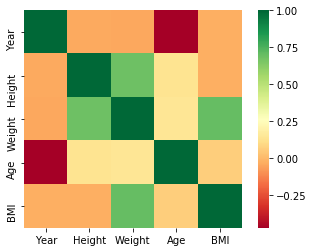

In [103]:
import seaborn as sns

sns.heatmap(df_roster_filtered.corr(), square=True, cmap='RdYlGn')
plt.show()

In [24]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

#df_training_data = df_rosters_pirates.loc[df_rosters_pirates['Year'] < 2018]

#print(df_training_data.shape)

In [104]:
df_roster_data = df_roster_filtered[['Height', 'Weight', 'BMI', 'Age' ]]

print(df_roster_data.head())

   Height  Weight        BMI  Age
0      71     202  28.172969   33
1      75     225  28.122760   38
2      76     230  27.996169   42
3      76     245  29.822006   31
4      76     225  27.387557   28


In [105]:
# Check there are no missing values
df_roster_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 4 columns):
Height    196 non-null int64
Weight    196 non-null int64
BMI       196 non-null float64
Age       196 non-null int64
dtypes: float64(1), int64(3)
memory usage: 6.2 KB


In [106]:
np_roster_target = df_roster_filtered.Position.values
print(np_roster_target[:5])

['Pitcher' 'Pitcher' 'Pitcher' 'Pitcher' 'Pitcher']


In [107]:
# Check the Target Numpy Array and Data Dataframe have the same number of samples or obeservations
print(df_roster_data.shape)
print(np_roster_target.shape)

(196, 4)
(196,)


In [108]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(df_roster_data, np_roster_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

Having fit a k-NN classifier, we will now use it to predict the label of a new data point. Since we filtered out the 2018 roster data for our trained/fitted data, we can now use the 2018 roster data for test data!

We need to measure the model's performance, since this is a classification predictive problem, accuracy is a commonly used metric. The accuracy of a classifier is defined as the number of correct predictions divided by the total number of datapoints. To compute the accuracy we are really interested in how well the model will perform on new data, so we will use use the samples that the algorithm has never seen before, rather than the data used to fit the classifier since it would not be indicative of the ability of the model to generalize. This is why we split the data into two sets of data, one for training and one for testing. So we Fit/Train the classifer on the training data set and make predictions on the test dataset, then compare the predictions with the known labels to compute the accuracy of our predictions.

In [109]:
# Import package to create train and test data sets
from sklearn.model_selection import train_test_split

# Splits the data into 70% train & 30% test data, 4 arrays are produced: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(df_roster_data, np_roster_target, 
                                                    test_size=0.3, random_state=21, stratify=np_roster_target)

knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Calculate Accuracy of our model
acc_score1 = knn.score(X_test, y_test)
print(acc_score1)

0.576271186440678


In [110]:


#df_rosters_pirates['BMI Class'] = df_rosters_pirates.apply(lambda row: get_bmi_class(row['BMI']), axis=1)

Let's compute and plot the training and testing accuracy scores for a variety of different neighbor values. By observing how the accuracy scores differ for the training and testing sets with different values of k, we will develop your intuition for overfitting and underfitting.

In [114]:
# KNeighbors Accuracy Helper Function
def plt_neighbors_accuracy(X_train, y_train):
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(1, 10)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors=k)

        # Fit the classifier to the training data
        knn.fit(X_train, y_train)

        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train)

        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_test, y_test)

    # Generate plot
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()


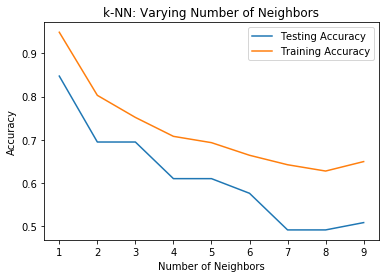

In [115]:
plt_neighbors_accuracy(X_train, y_train)

It looks like the test accuracy is highest when using 1, 4, 5, 7 or 8 neighbors. Using 9 neighbors or more seems to result in a simple model that underfits the data. 

In [116]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Calculate Accuracy of our model
acc_score2 = knn.score(X_test, y_test)
print(acc_score2)

0.6949152542372882


Accuracy alone is not always an informative metrics for classifcation. Let's dive more deeply into evaluating hte performance of our classiers by computing the confusion matrix and generating a classificatio nreport.

In [117]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[ 2  3  0  1]
 [ 1 11  0  2]
 [ 0  3  3  3]
 [ 2  3  0 25]]


In [118]:
# Classification report (Precision, Recall, F1 score)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Catcher       0.40      0.33      0.36         6
   Infielder       0.55      0.79      0.65        14
  Outfielder       1.00      0.33      0.50         9
     Pitcher       0.81      0.83      0.82        30

   micro avg       0.69      0.69      0.69        59
   macro avg       0.69      0.57      0.58        59
weighted avg       0.73      0.69      0.68        59



In [119]:
# Feature Engineering
df_roster_newfeats = df_roster_filtered.copy()

df_roster_newfeats['IsOverweight'] = df_roster_newfeats['BMI Class'].apply(lambda x: int(x != 'Normal' and x != 'Underweight'))
df_roster_newfeats.head()

,Year,Position,Player,Height,Weight,Age,BMI,BMI Class,IsOverweight
0,2015,Pitcher,Antonio Bastardo,71,202,33,28.172969,Overweight,1
1,2015,Pitcher,Joe Blanton,75,225,38,28.122760,Overweight,1
2,2015,Pitcher,A.J. Burnett,76,230,42,27.996169,Overweight,1
3,2015,Pitcher,Arquimedes Caminero,76,245,31,29.822006,Overweight,1
4,2015,Pitcher,Gerrit Cole,76,225,28,27.387557,Overweight,1


In [120]:
df_roster_newfeats['BMI Class Code'] = df_roster_newfeats['BMI Class'].astype('category').cat.codes
df_roster_newfeats.head()

,Year,Position,Player,Height,Weight,Age,BMI,BMI Class,IsOverweight,BMI Class Code
0,2015,Pitcher,Antonio Bastardo,71,202,33,28.172969,Overweight,1,3
1,2015,Pitcher,Joe Blanton,75,225,38,28.122760,Overweight,1,3
2,2015,Pitcher,A.J. Burnett,76,230,42,27.996169,Overweight,1,3
3,2015,Pitcher,Arquimedes Caminero,76,245,31,29.822006,Overweight,1,3
4,2015,Pitcher,Gerrit Cole,76,225,28,27.387557,Overweight,1,3


In [121]:
df_roster_data = df_roster_newfeats[['Height', 'Weight', 'Age', 'BMI Class Code','IsOverweight']]
df_roster_data.head()


,Height,Weight,Age,BMI Class Code,IsOverweight
0,71,202,33,3,1
1,75,225,38,3,1
2,76,230,42,3,1
3,76,245,31,3,1
4,76,225,28,3,1


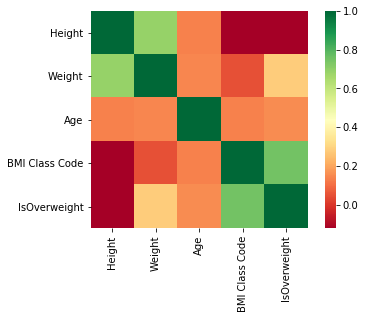

In [122]:
sns.heatmap(df_roster_data.corr(), square=True, cmap='RdYlGn')
plt.show()

In [123]:
# Splits the data into 70% train & 30% test data, 4 arrays are produced: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(df_roster_data, np_roster_target, 
                                                    test_size=0.3, random_state=21, stratify=np_roster_target)

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Calculate Accuracy of our model
acc_score3 = knn.score(X_test, y_test)
print(acc_score3)

0.6949152542372882


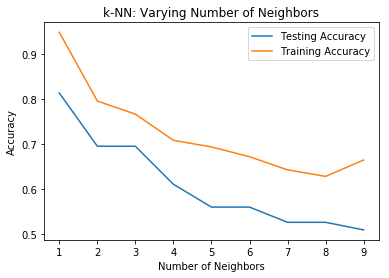

In [124]:
plt_neighbors_accuracy(X_train, y_train)

In [95]:
# Calculate Accuracy of our model
acc_score2 = knn.score(X_test, y_test)
print('Original accuracy score {0}, adjusted neighbors accuracy score {1}, additional features accuracy score {2}'.
      format(acc_score1, acc_score2, acc_score3))

Original accuracy score 0.5423728813559322, adjusted neighbors accuracy score 0.6949152542372882, additional features accuracy score 0.6949152542372882


In [ ]:
# Logistic Regression

The Numerical EDA above gave us some very important information, such as the names and data types of the columns, and the dimensions of the DataFrame. 

Now let's get a better understanding of the data by exploring the data visual EDA. scatter_matrix in seaborn.

In [22]:
# Set default matplot style
#plt.style.use('ggplot')

#_ = plt.scatter(x=df_rosters_pirates.Weight, y=df_rosters_pirates.Height, c=df_rosters_pirates.Position)
#plt.xlabel('Weight (lbs)')
#plt.ylabel('Height (Inches)')
#plt.title('Position Weight vs Height')

#plt.show()

#_ = pd.scatter_matrix(df_rosters_pirates)